# Workbook for Project 01: Writing a Data Scientist Blog Post (Udacity Data Science Nanodegree)
## Renting Out Your Room on Airbnb in Zürich

This workbook documents the data science and analysis process to gain insights from Airbnb rentals for Zürich, Switzerland.
The data is provided by [Inside Airbnb](http://insideairbnb.com/get-the-data/), not by the site itself. Do consider making a donation to their efforts.

**Download the data first by sourcing `01-download-data.py`.**

The process follows [CRISP-DM](https://www.datascience-pm.com/crisp-dm-2/) principles.

Criteria: https://review.udacity.com/#!/rubrics/1507/view

In [3]:
import pandas as pd
# get root path of git repo
# https://stackoverflow.com/questions/22081209/find-the-root-of-the-git-repository-where-the-file-lives
import git
repo = git.Repo('.', search_parent_directories=True)

In [20]:
# read data from CSV
path_listings = repo.working_tree_dir + '/data/listings.csv'
listings_1 = pd.read_csv(path_listings)

# add detailed listings
path_listings_detailed = repo.working_tree_dir + '/data/listings_detailed.csv'
# from this one, we need the columns instant_bookable and id
listings_detailed = pd.read_csv(path_listings_detailed).filter(['instant_bookable', 'id'])

# join the two files and drop the 
listings = listings_1.merge(listings_detailed, on='id')

Let's preview the data

In [21]:
listings.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,instant_bookable
0,"Clean, central, quiet",377532,Simona,Kreis 3,Sihlfeld,47.37374,8.51957,Entire home/apt,100,1125,49,2019-04-27,0.41,1,329,0,NaN,f
1,Stadium Letzigrund - by Airhome,475053,James,Kreis 3,Sihlfeld,47.38038,8.50461,Entire home/apt,184,1,50,2021-07-16,0.38,18,0,1,NaN,t
2,marvelous LOFT in SIHLCITY Zürich,697307,Erhan,Kreis 3,Alt-Wiedikon,47.35724,8.52304,Entire home/apt,200,3,0,NaN,NaN,1,33,0,NaN,f
3,"a lovely place, top location",854016,Delphine,Kreis 2,Enge,47.36565,8.52753,Private room,60,5,9,2016-05-10,0.07,1,149,0,NaN,f
4,Unique apartment in prime location,803942,H I Jaf,Kreis 7,Witikon,47.35041,8.59630,Private room,71,2,47,2021-08-12,0.38,1,0,2,NaN,t


## Data Completeness

In [6]:
### Data Completeness
# check if all columns are present
(
pd.DataFrame(
    listings
    .isnull()
    .mean()
    .reset_index()
)
    .rename(columns={'index': 'column', 0: 'missing'})
    .sort_values('missing', ascending=False)
)

,column,missing
17,license,1.000000
13,reviews_per_month,0.201613
12,last_review,0.201613
1,name,0.000538
16,number_of_reviews_ltm,0.000000
15,availability_365,0.000000
14,calculated_host_listings_count,0.000000
11,number_of_reviews,0.000000
10,minimum_nights,0.000000
0,id,0.000000


Variable `reviews_per_month`, `last_review` and `name` all have low levels of missings, whereas `license` is not available for any of them.
The rest of the variables seem to be in order without any missings. Imputation will occur later on for the former three variables, wheras `license` will be dropped altogether.

## Distribution of the Dependendent Variable

To model pricing, we need to find out what distribution the dependent variable `price` most closely resembles. Let's look at the histogram for that.

(0.0, 280.0)

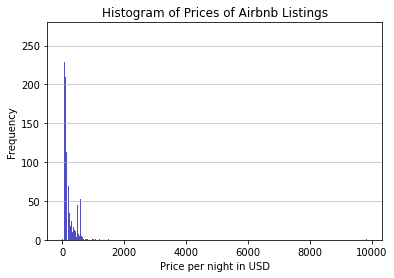

In [7]:
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x = listings.price, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price per night in USD')
plt.ylabel('Frequency')
plt.title('Histogram of Prices of Airbnb Listings')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
# price_hist = listings.price.hist(bins=100, grid=True, rwidth=0.9)
# # price_hist.set_xlabel('Price per Night in USD')
# maxfreq = n.max()
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 2000.0)

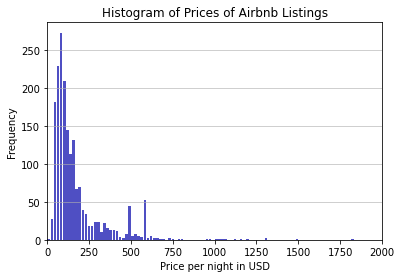

In [8]:
# one more time, but zoomed in on the x-axis to see the skew and kurtosis
n, bins, patches = plt.hist(x = listings.price, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price per night in USD')
plt.ylabel('Frequency')
plt.title('Histogram of Prices of Airbnb Listings')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.xlim(xmin = 0, xmax = 2000)

The distribution is strongly right-skewed. 
Which one could it be? 
Let's use the Fitter library to find out.

,sumsquare_error,aic,bic,kl_div
burr,0.000008,1982.126058,-35766.813087,inf
cauchy,0.000032,2030.189974,-33228.846857,inf
beta,0.000048,2492.071409,-32419.335689,inf
norm,0.000114,4239.274689,-30834.873326,inf
gamma,0.000239,52554.930038,-29458.460107,inf


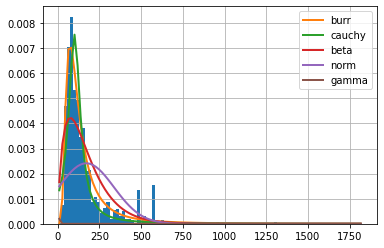

In [9]:
# get the values as separate object
price_vals = listings.price.values
# import necessary functions
from fitter import Fitter, get_common_distributions, get_distributions
f = Fitter(price_vals,
           distributions=['gamma',
                          "beta",
                          'cauchy',
                          "burr",
                          "norm"],
                          xmax=2000)
f.fit()
f.summary()

Though both the Cauchy, Burr and Beta distributions (as well as others many others that are not shown here) yield lower AIC values and are thus a better fit for the data, they are not readily available as regression models in Python.

I wil thus model the dependent variable as normally distributed.

Let's first scan the data for any correlations that may occur exceptionally strongly.

<AxesSubplot:>

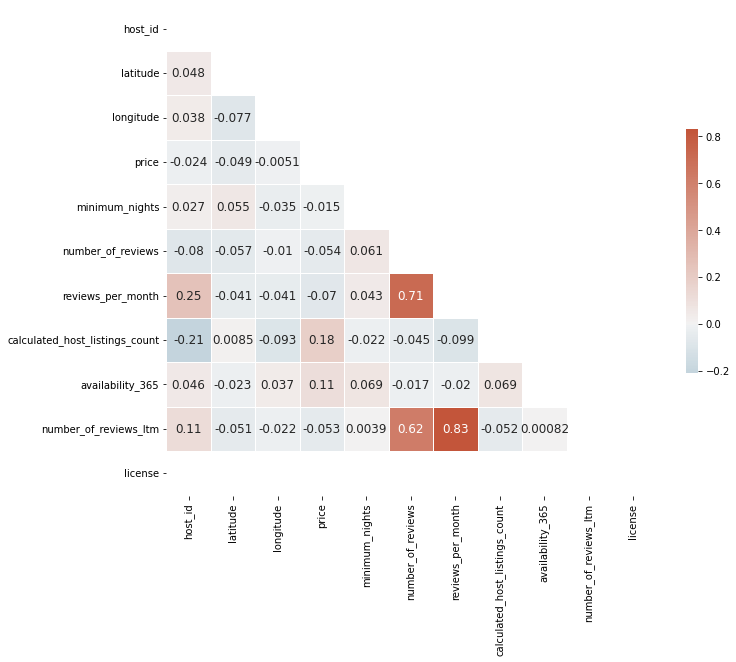

In [23]:
import seaborn as sns
# correlation matrix with seaborn
corr = listings.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# customization tips https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, annot_kws={"size": 12})


The correlation matrix shows us some first insights:

- high numbers of listings appear to be positively associated with higher rental prices (`calculated_host_listings_count` and `price`)
- columns `reviews_per_month` and `number_of_reviews` are near copies, meaning one of them will need to be dropped from the model

## Graph of Airbnb Rentals

Let's see where those rentals are.
https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/interactive-maps/

In [59]:

import folium
from folium import plugins
# make color dependent on price
# ∆ todo: change to https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
listings['price_color'] = pd.cut(listings['price'], bins=4, 
                              labels=['green', 'yellow', 'orange', 'red'])
zurich_map = folium.Map(location=[47.37, 8.54], zoom_start=12, tiles='Stamen Toner')
for lat, lng, name, price_color, price in zip(listings.latitude, listings.longitude, listings.name, listings.price_color, listings.price):
    folium.CircleMarker(location=[lat, lng], popup= {str(name) + '' +  str(price) + ' USD/night'}, radius=2, 
    color = price_color).add_to(zurich_map)
zurich_map